# Simple Okada generated runup simulation

## Setup Environment

We assume you have installed `anuga` in your `python` environment. 

### Setup inline graphics and animation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import files

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

### Tohoku Folder

Change into the Tohoku folder (if you have not done that already)

In [2]:
print(f'Current directory {os.getcwd()}')
try:
    os.chdir('Tohoku')
except:
    pass


Current directory /home/steve/Tohoku


## Setup Anuga Model

### Create Domain

In [3]:
import anuga


# Create domain
dx = dy = 1000
L = 160000
W = 160000


# Create topography
def topography(x, y):
    el = np.maximum( 20.0 - x/1000, -1000.0)
    return el


domain = anuga.rectangular_cross_domain(int(L/dx), int(W/dy), len1=L, len2=W)

domain.set_name('simple_runup')
domain.set_quantity('elevation', function=topography, location='centroids')

### Calculate surface deformation

Using commonly assumed characteristics of an idealised Tohoku fault, calculate the surface deformation using the Okada transformation. 

Figure files for each frame will be stored in _plot



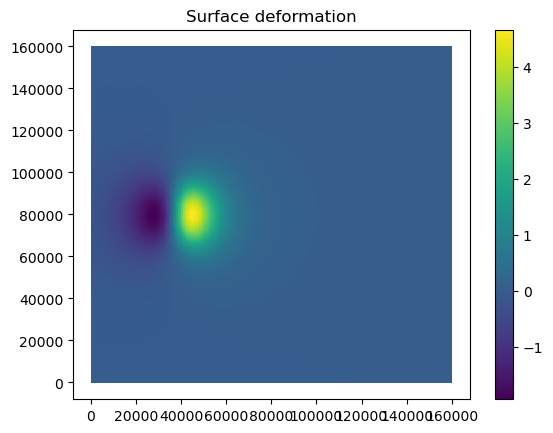

In [6]:
#from anuga.tsunami_source.okada_tsunami import earthquake_source

x0 = 40000.0
y0 = 80000.0
depth = 15000.0
strike = 180.0
dip = 15.0
length = 20000.0
width = 6000.0
slip = 60.0
rake = 90.0
opening = 0.0
nu = 0.25


# Run one instance of the okada KL field as defined by the choice of iseed
#import okada_kl_subfaults as okl
import okada

x = domain.centroid_coordinates[:,0]
y = domain.centroid_coordinates[:,1]

uE,uN,uZ = okada.forward(x,y, xoff=x0, yoff=y0, 
                   depth=depth, length=length, width=width,
                   slip=slip, opening=opening,
                   strike=strike, dip=dip, rake=rake,
                   nu=nu)

    
# The default argument values are appropriate for the Tohoku earth quake
#uE,uN,uZ,slips = okl.deformation(x, y, xoff=300000.0, yoff=250000.0, E_subfault=5, N_subfault=10, iseed=1001)

dplotter = anuga.Domain_plotter(domain)#absolute=True)
plt.tripcolor(dplotter.triang,
              facecolors = uZ,
              #edgecolors='k',
              cmap='viridis')
plt.title('Surface deformation')
plt.colorbar();


### Apply deformation to domain

Apply the calculated deformation to the domain elevation and stage quantities

point near coast id 12318, elevation 0.16666666666666785, stage 0.16666666666666785 uZ -0.08544385944331225
point near coast id 12318, elevation 0.0812228072233556, stage 0.0812228072233556 uZ -0.08544385944331225
Figure files for each frame will be stored in _plot

19.818980561567287 -1.9376595649950827
19.818980561567287 -139.83230612532708
139.83333333333334 0.0


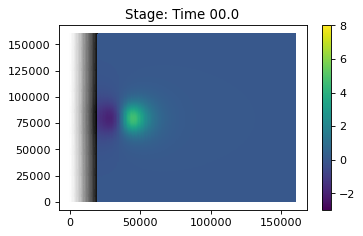

In [7]:
Elevation = domain.quantities['elevation'].centroid_values
Stage = domain.quantities['stage'].centroid_values

# Clean up stage so that stage >= elevation
Stage[:] = np.maximum(Stage, Elevation)

location = [20000, 40000]
#location = [1, 40000]
tri_id = domain.get_triangle_containing_point(location)
print(f'point near coast id {tri_id}, elevation {Elevation[tri_id]}, stage {Stage[tri_id]} uZ {uZ[tri_id]}')


Elevation[:] = Elevation + uZ
Stage[:] = Stage + uZ

print(f'point near coast id {tri_id}, elevation {Elevation[tri_id]}, stage {Stage[tri_id]} uZ {uZ[tri_id]}')


dplotter = anuga.Domain_plotter(domain)

print (np.max(dplotter.stage), np.min(dplotter.stage))
print (np.max(dplotter.elev), np.min(dplotter.elev))
print (np.max(dplotter.depth), np.min(dplotter.depth))

dplotter.plot_stage_frame(vmin=-3.0, vmax=8.0)


### Boundary Conditions

Use transmisive boundary conditoin on the ocean boundaries. Set an inflow stage value to 0. (this assumes that the surface deformation is very close to 0, ie the domain is big enough that the ocean BC are far away from the eathquake deformation)

In [8]:
Br = anuga.Reflective_boundary(domain)
Bf = anuga.Flather_external_stage_zero_velocity_boundary(domain,lambda t :0.0)
Bt = anuga.Transmissive_n_momentum_zero_t_momentum_set_stage_boundary(domain,lambda t :0.0)
# Boundary conditions
domain.set_boundary({'left': Br,
                         'bottom': Bf,
                         'right': Bf,
                         'top': Bf})

### Interrogation of points

Test elevation and stage at a point near the shore and on the ocean boundary

In [9]:
# point near shore line
location = [20000, 40000]
tri_id_s = domain.get_triangle_containing_point(location)
print(f'centroid with triangle id {tri_id_s} near coast has elevation {Elevation[tri_id_s]}, stage {Stage[tri_id_s]} and uZ {uZ[tri_id_s]}')
# point on transmissive ocean boundary
location = [80000, 1]
tri_id_o = domain.get_triangle_containing_point(location)
print(f'centroid with triangle id {tri_id_o} near transmissive boundary has elevation {Elevation[tri_id_o]}, stage {Stage[tri_id_o]} and uZ {uZ[tri_id_o]}')


centroid with triangle id 12318 near coast has elevation 0.0812228072233556, stage 0.0812228072233556 and uZ -0.08544385944331225
centroid with triangle id 50562 near transmissive boundary has elevation -59.8383536880146, stage -0.0050203546812699375 and uZ -0.0050203546812699375


## Run model

### Evolve

In [10]:
import time
t0 = time.time()
min = 60
hour = 3600

# Initial run without any event
for t in domain.evolve(yieldstep=5*min, finaltime=3*hour):
    dplotter.save_stage_frame(vmin=-3.0,vmax=8.0)

    domain.print_timestepping_statistics()
    print(f'centroid near coast has elevation {Elevation[tri_id_s]}, stage {Stage[tri_id_s]} and height {Stage[tri_id_s]-Elevation[tri_id_s]}')


print ('That took %.2f seconds' %(time.time()-t0))


/home/steve/anuga_core/anuga/shallow_water/boundaries.py:1161: RuntimeWarning: invalid value encountered in multiply
  w1 = 0.0 - sqrt_g_on_depth_inside * stage_outside
/home/steve/anuga_core/anuga/shallow_water/boundaries.py:1165: RuntimeWarning: invalid value encountered in divide
  (n2 * Xmom.boundary_values[ids] - n1 * Ymom.boundary_values[ids])/depth_inside,
/home/steve/anuga_core/anuga/shallow_water/boundaries.py:1168: RuntimeWarning: invalid value encountered in divide
  w3 = ndotq_inside/depth_inside + sqrt_g_on_depth_inside*Stage.boundary_values[ids]


Time = 0.0000 (sec), steps=0 (585s)
centroid near coast has elevation 0.0812228072233556, stage 0.0812228072233556 and height 0.0
Time = 300.0000 (sec), delta t in [4.05198295, 4.05203200] (s), steps=75 (4s)
centroid near coast has elevation 0.0812228072233556, stage 0.0812228072233556 and height 0.0
Time = 600.0000 (sec), delta t in [4.05196743, 4.05198295] (s), steps=75 (4s)
centroid near coast has elevation 0.0812228072233556, stage 0.0812228072233556 and height 0.0
Time = 900.0000 (sec), delta t in [4.05195011, 4.05196742] (s), steps=75 (4s)
centroid near coast has elevation 0.0812228072233556, stage 0.0812228072233556 and height 0.0
Time = 1200.0000 (sec), delta t in [4.05192678, 4.05195010] (s), steps=75 (4s)
centroid near coast has elevation 0.0812228072233556, stage 0.0812228072233556 and height 0.0
Time = 1500.0000 (sec), delta t in [4.05188784, 4.05192677] (s), steps=75 (4s)
centroid near coast has elevation 0.0812228072233556, stage 0.0812228072233556 and height 0.0
Time = 1

### Plot results of Simulation

In [11]:
dplotter.make_stage_animation()